# Kaggle Digit Recognizer

## Simple CNN

Here we'll build a simple CNN with two conv/maxpool layers and two dense layers.

In [1]:
import numpy as np
import pandas as pd
import PIL
import time
import datetime

import torch
import torchvision
import torchsummary

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

notebook_start = time.time()

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using {0} gpus.'.format(torch.cuda.device_count()))

Using 1 gpus.


### Constants

In [3]:
BATCH_SIZE = 256
IMG_SIZE = (1, 28, 28)

### MNIST data set

Rather than use the CSV file Kaggle provides with training data, let's use Pytorch's built in MNIST data (that way we won't have to define our own custom dataset object).

Note that we'll load the test data set, but we only use that for estimating our test error, it doesn't factor into training decisions.

In [4]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            ])

train_data = torchvision.datasets.MNIST(root='./MNIST_data/',
                                        train=True,
                                        download=True,
                                        transform=transforms)
TRAIN_SAMPLE_SIZE = len(train_data.data)


val_data = torchvision.datasets.MNIST(root='./MNIST_data/',
                                        train=False,
                                        download=True,
                                        transform=transforms)
VAL_SAMPLE_SIZE = len(val_data.data)

print('Training data: {0} obs\nValidation data: {1} obs.'.format(TRAIN_SAMPLE_SIZE, VAL_SAMPLE_SIZE))


Training data: 60000 obs
Validation data: 10000 obs.


In [5]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Let's plot an example image.

In [6]:
ix, (X, y) = next(enumerate(train_dataloader))

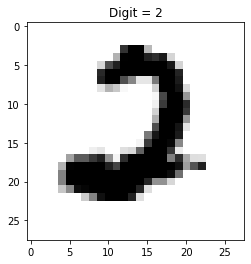

In [7]:
plt.imshow(X[0].squeeze(), cmap='gray_r')
plt.title('Digit = {0}'.format(y[0]))
plt.show()

### Construct CNN

Let's have the CNN structure be:

    Convolution (32 filters) -> BatchNorm -> ReLU -> Maxpool -> 
    Convolution (64 filters) -> BatchNorm -> ReLU -> Maxpool -> 
    Flatten -> 
    Dense(256) -> ReLU -> Dropout -> 
    Dense(256) -> ReLU -> Dropout -> 
    Dense(10)

In [8]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Conv block 1
        self.conv1_conv = torch.nn.Conv2d(in_channels=1,
                                          out_channels=32,
                                          kernel_size=3,
                                          padding=1,
                                          stride=1)
        self.conv1_batchnorm = torch.nn.BatchNorm2d(32)
        self.conv1_relu = torch.nn.ReLU()
        self.conv1_maxpool = torch.nn.MaxPool2d(kernel_size=2)
                
        # Conv block 2
        self.conv2_conv = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=3,
                                          padding=1,
                                          stride=1)
        self.conv2_batchnorm = torch.nn.BatchNorm2d(64)
        self.conv2_relu = torch.nn.ReLU()
        self.conv2_maxpool = torch.nn.MaxPool2d(kernel_size=2)
                
        # Dense block 1
        self.dense1_dense = torch.nn.Linear(in_features=64*7*7, out_features=256)
        self.dense1_relu = torch.nn.ReLU()
        self.dense1_dropout = torch.nn.Dropout(.4)
        
        # Dense block 2
        self.dense2_dense = torch.nn.Linear(in_features=256, out_features=256)
        self.dense2_relu = torch.nn.ReLU()
        self.dense2_dropout = torch.nn.Dropout(.4)
        
        # Output layer
        self.output = torch.nn.Linear(in_features=256, out_features=10)
         
        return None
    
    def forward(self, x):
        
        # Conv 1
        x = self.conv1_conv(x)
        x = self.conv1_batchnorm(x)
        x = self.conv1_relu(x)
        x = self.conv1_maxpool(x)
                
        # Conv 2
        x = self.conv2_conv(x)
        x = self.conv2_batchnorm(x)
        x = self.conv2_relu(x)
        x = self.conv2_maxpool(x)
        
        # Flatten
        x = torch.flatten(x, start_dim=1)
        
        # Dense 1
        x = self.dense1_dense(x)
        x = self.dense1_relu(x)
        x = self.dense1_dropout(x)
        
        # Dense 2
        x = self.dense2_dense(x)
        x = self.dense2_relu(x)
        x = self.dense2_dropout(x)
        
        # Output
        x = self.output(x)
        
        return x
        

Instantiate the network

In [9]:
net = CNN().to(device)

Display the architecture

In [10]:
torchsummary.summary(net, input_size=(1, 28, 28, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                  [-1, 256]         803,072
             ReLU-10                  [-1, 256]               0
          Dropout-11                  [-1, 256]               0
           Linear-12                  [-1, 256]          65,792
             ReLU-13                  [-1, 256]               0
          Dropout-14                  [

### Training function

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [12]:
class ModelTrainer:
    '''Train a neural net while keeping track of running loss/accuracy.'''
    
    def __init__(self, model, criterion, optimizer, train_dataloader, val_dataloader=None):
        '''
        Args:
        model (torch neural net): network to be trained.
        criterion (torch.nn loss function): loss function.
        optimizer (torch.optim optimizer): optimizer.
        '''
        
        # User specified parameters
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        
        # Values to keep track of
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        
        # Constants
        self.NUM_TRAIN_BATCHES = len(self.train_dataloader)
        self.NUM_VAL_BATCHES = len(self.val_dataloader)
        self.epoch_completion_time = 0.0
        
        return None
    
    def train(self):
        ''' Train the model on the whole data set once.'''
        
        # Set training mode
        self.model.train();
        
        start_time = time.time()
        for batch_no, (images, labels) in enumerate(self.train_dataloader):
            self.optimizer.zero_grad()

            images, labels = images.to(device), labels.to(device)

            # Run images through the net
            predicted_labels = self.model(images)

            # Determine loss and run backprop
            loss = self.criterion(predicted_labels, labels)
            loss.backward()
            self.optimizer.step()
            
            
        end_time = time.time()
        self.epoch_completion_time = end_time - start_time
        
        return None

    def trainloss(self):
        '''Evaluates loss and accuracy on training set.
        Note that we don't do this in the training loop itself because
        dropout is on while training, which can result in validation loss 
        being better than training loss. Here we turn off dropout to evaluate.
        That way the validation loss should always be strictly larger than 
        training loss.'''
        
        # Set evaluation model
        self.model.eval();
        
        running_loss = 0.0
        running_acc = 0.0
        
        for batch_no, (images, labels) in enumerate(self.train_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            predicted_logits = self.model(images)
            predicted_labels = torch.argmax(predicted_logits, dim=1)
            
            loss = self.criterion(predicted_logits, labels)
            running_loss += (1/BATCH_SIZE) * loss.item()
            
            running_acc += (1/BATCH_SIZE) * torch.sum(predicted_labels == labels).item()
            
        self.train_loss.append(running_loss/self.NUM_TRAIN_BATCHES)
        self.train_acc.append(running_acc/self.NUM_TRAIN_BATCHES)    
        
        return None
    
    
    def valloss(self):
        '''Evaluates loss and accuracy on validation set'''
        assert self.val_dataloader != None
        
        # Set evaluation model
        self.model.eval();
        
        running_loss = 0.0
        running_acc = 0.0
        
        for batch_no, (images, labels) in enumerate(self.val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            predicted_logits = self.model(images)
            predicted_labels = torch.argmax(predicted_logits, dim=1)
            
            loss = self.criterion(predicted_logits, labels)
            running_loss += (1/BATCH_SIZE) * loss.item()
            
            running_acc += (1/BATCH_SIZE) * torch.sum(predicted_labels == labels).item()
            
        self.val_loss.append(running_loss/self.NUM_VAL_BATCHES)
        self.val_acc.append(running_acc/self.NUM_VAL_BATCHES)    
        
        return None
    
    def plot_metrics(self):
        '''Plots training and validation metrics'''
        
        fig, ax = plt.subplots(1, 2, figsize=(2*1.618*4, 4))
        
        ax[0].plot(self.train_loss, 'o-', label='Train')
        ax[0].plot(self.val_loss, 'o-', label='Val')
        ax[0].set_title('Loss')
        
        ax[1].plot(self.train_acc, 'o-', label='Train')
        ax[1].plot(self.val_acc ,'o-', label='Val')
        ax[1].set_title('Accuracy')
        
        plt.legend()
        
        # Clear current output and show graph
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.05)
        
        plt.show()
        
        return None

### Training loop

In [13]:
trainer = ModelTrainer(net, criterion, optimizer, train_dataloader, val_dataloader)

In [14]:
epochs = 100

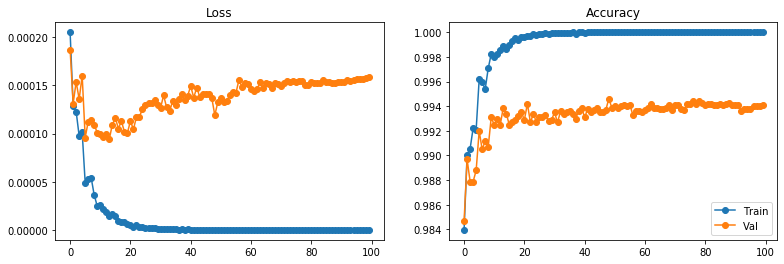

Completed 100 out of 100 epochs in 00:27:25.


In [15]:
start_time = time.time()

for epoch in range(epochs):
    trainer.train()
    trainer.trainloss()
    trainer.valloss()
    scheduler.step()
    
    trainer.plot_metrics()
    
    time_delta = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print("Completed {0} out of {1} epochs in {2}.".format(epoch + 1, epochs, time_delta))

In [16]:
print('Final validation accuracy: {0:.4f}'.format(trainer.val_acc[-1]))

Final validation accuracy: 0.9941


Note that the Kaggle score is 0.99928. Recall that Kaggle only uses 25% of the test set for evaluating.

### Predict Kaggle images 

Let's create a custom data loader to draw batches from the Kaggle test set.

In [17]:
class KaggleTestSet(torch.utils.data.Dataset):
    '''Torch Dataset class to draw samples from Kaggle digit recognizer test set.'''
    
    def __init__(self, path, transforms):
        self.test_data = pd.read_csv(path)
        self.transforms = transforms
        return None
    
    def __len__(self):
        return len(self.test_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
            
        image = self.test_data.iloc[idx, :].astype('float')
        image = torch.tensor(image).reshape(1, 28, 28)
        
        # Normalize to be same as inputs to our CNN
        image = torchvision.transforms.Normalize((0.1307,), (0.3081,))(image)
        
        
        return image
        
    

In [18]:
path = './kaggle_data/test.csv'
kaggle_test_set = KaggleTestSet(path, transforms)

In [19]:
kaggle_dataloader = torch.utils.data.DataLoader(kaggle_test_set, batch_size=512, shuffle=False)

In [20]:
net.eval();
predicted_label = []

for batch_no, images in enumerate(kaggle_dataloader):
    
    images = images.to(device)
    logit = net(images)
    predicted_label.extend(torch.argmax(logit, dim=1).to('cpu').numpy())
    

Write predictions to a csv.

In [21]:
ImageId = [i + 1  for i in range(len(predicted_label))]
df = pd.DataFrame({'ImageId': ImageId, 'Label': predicted_label})
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [22]:
df.to_csv('./kaggle_data/predictions.csv', index=False)

Check the predictions are okay just to make sure we normalized the kaggle images correctly.

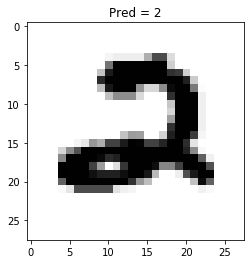

In [23]:
net.eval();
batch_no, X = next(enumerate(kaggle_dataloader))

X = X[0]
y_hat = torch.argmax(net(X.to(device).unsqueeze(0)), dim=1).item()

plt.imshow(X.squeeze(), cmap='gray_r')
plt.title('Pred = {0}'.format(y_hat))
plt.show()

In [24]:
notebook_execution_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - notebook_start))

print('Notebook run time: {0}'.format(notebook_execution_time))

Notebook run time: 00:29:57


When uploaded to Kaggle we got an accuracy of 0.99928 on the test set, which landed us at 80th place at time of submission. Not bad, but let's try to do better.